In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

In [10]:
df = pd.read_parquet("../data/usa_00001_clean.parquet")

df.head()

,YEAR,SAMPLE,SERIAL,CBSERIAL,HHWT,CLUSTER,STATEFIP,STRATA,GQ,PERNUM,...,EMPSTATD,LABFORCE,CLASSWKR,CLASSWKRD,OCC,IND,WKSWORK2,UHRSWORK,FTOTINC,INCWAGE
0,2023,202301,2.0,2.023010e+12,27.0,2.023000e+12,1,10001.0,3,1.0,...,30,1,0,0,0,0,0,0,9999999.0,0.0
1,2023,202301,3.0,2.023010e+12,47.0,2.023000e+12,1,40201.0,4,1.0,...,30,1,0,0,0,0,0,0,9999999.0,0.0
2,2023,202301,5.0,2.023010e+12,57.0,2.023000e+12,1,280201.0,4,1.0,...,30,1,2,22,7810,4971,2,28,9999999.0,2500.0
3,2023,202301,6.0,2.023010e+12,52.0,2.023000e+12,1,120201.0,4,1.0,...,30,1,2,28,4600,7860,1,30,9999999.0,500.0
4,2023,202301,7.0,2.023010e+12,43.0,2.023000e+12,1,180101.0,3,1.0,...,30,1,2,22,8990,3570,0,0,9999999.0,0.0


In [12]:
df["citizen_cat"] = df["CITIZEN"].map({
    0: "US-born citizen",
    1: "Born abroad to US parents",
    2: "Naturalized citizen",
    3: "Non-citizen"
})
df["citizen_cat"].value_counts(dropna=False)

citizen_cat
US-born citizen              1687258
Naturalized citizen           166840
Non-citizen                   150925
Born abroad to US parents      23348
Name: count, dtype: int64

In [13]:
(
    df.groupby("citizen_cat")
      .agg(
          n=("INCWAGE", "size"),
          mean_wage=("INCWAGE", "mean"),
          median_wage=("INCWAGE", "median")
      )
      .sort_values("mean_wage", ascending=False)
)

,n,mean_wage,median_wage
citizen_cat,,,
Naturalized citizen,166840,62202.717226,40000.0
Born abroad to US parents,23348,53272.402347,32000.0
US-born citizen,1687258,48119.077535,30000.0
Non-citizen,150925,41182.964002,22000.0


In [7]:
df_emp = df[df["EMPSTAT"].isin([1, 2])]
df_emp.head()

,YEAR,SAMPLE,SERIAL,CBSERIAL,HHWT,CLUSTER,STATEFIP,STRATA,GQ,PERNUM,...,LABFORCE,CLASSWKR,CLASSWKRD,OCC,IND,WKSWORK2,UHRSWORK,FTOTINC,INCWAGE,citizen_cat
5,2023,202301,10.0,2.023010e+12,41.0,2.023000e+12,1,280201.0,4,1.0,...,2,2,27,5240,7870,2,10,9999999.0,3700.0,US-born citizen
7,2023,202301,12.0,2.023010e+12,39.0,2.023000e+12,1,210101.0,4,1.0,...,2,2,22,9610,8780,2,10,9999999.0,2000.0,US-born citizen
15,2023,202301,22.0,2.023010e+12,34.0,2.023000e+12,1,160001.0,4,1.0,...,2,2,22,7340,7870,1,15,9999999.0,3600.0,US-born citizen
16,2023,202301,23.0,2.023010e+12,3.0,2.023000e+12,1,140301.0,4,1.0,...,2,2,22,7905,3291,6,40,9999999.0,20000.0,US-born citizen
19,2023,202301,27.0,2.023010e+12,30.0,2.023000e+12,1,110001.0,4,1.0,...,2,2,27,4600,7870,2,12,9999999.0,2200.0,US-born citizen


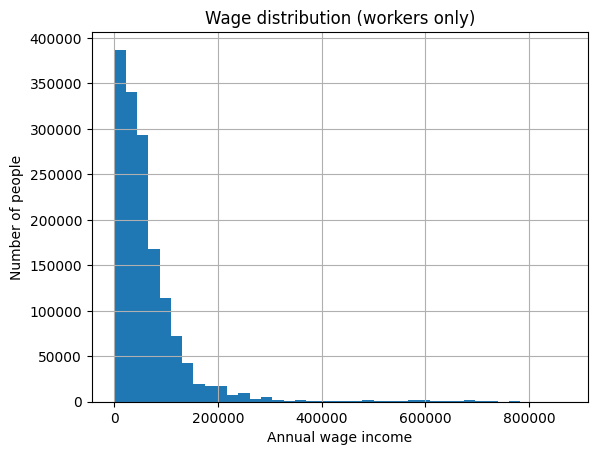

In [10]:
df_emp["INCWAGE"].hist(bins=40)
plt.xlabel("Annual wage income")
plt.ylabel("Number of people")
plt.title("Wage distribution (workers only)")
plt.show()

In [14]:
df_reg = df[(df["INCWAGE"] > 0) & df["EMPSTAT"].isin([1, 2])]

model = smf.ols(
    formula="np.log(INCWAGE) ~ C(citizen_cat) + AGE + C(SEX) + EDUC",
    data=df_reg
).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        np.log(INCWAGE)   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                 7.137e+04
Date:                Sun, 30 Nov 2025   Prob (F-statistic):               0.00
Time:                        21:03:27   Log-Likelihood:            -1.9873e+06
No. Observations:             1421126   AIC:                         3.975e+06
Df Residuals:                 1421119   BIC:                         3.975e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [15]:
df_reg["citizen_cat"].value_counts()

citizen_cat
US-born citizen              1180655
Naturalized citizen           123920
Non-citizen                    99903
Born abroad to US parents      16648
Name: count, dtype: int64